<a href="https://colab.research.google.com/github/Thiiagoo777/Mielo1/blob/main/pipeline_filtragem_de_risco_mf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PEGASO (Prognóstico por Evidência Genética Somática)**

O propósito deste projeto é identificar e filtrar variantes somáticas associadas a prognósticos desfavoráveis na doença de Mielofibrose.

Este repositório compreende todos os arquivos essenciais para a filtragem e análise das variantes relacionadas ao prognóstico da Mielofibrose. Aqui, encontram-se os dados anotados para análise, o script de filtragem e outros arquivos relevantes.

Os arquivos VCF do projeto foram convertidos previamente da versão do genoma hg19 para hg38 utilizando o programa gatk LiftoverVcf com as posições hg19ToHg38.over.chain da UCSC.

Os genes considerados para a filtragem foram obtidos do artigo fundador do GIPSS – Sistema de Prognóstico por Pontuação Inspirado em dados Genéticos (https://doi.org/10.1038/s41375-018-0107-z). São eles:

* CALR
* ASXL1
* SRSF2
* EZH2
* IDH1
* IDH2
* U2AF1

## 1. Preparação ambiente de trabalho





In [ ]:
# Clonar github do projeto lmabrasil-hg48.git
%%bash
rm -rf lmabrasil-hg38
git clone https://github.com/renatopuga/lmabrasil-hg38

Cloning into 'lmabrasil-hg38'...


In [ ]:
# Clonar github contendo amostras do projeto lmabrasil convertidos para hg38
!git clone https://github.com/bioinfoamos01/projetolma.git

Cloning into 'projetolma'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 35 (delta 29), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (35/35), 28.22 MiB | 2.66 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
# Remover arquivo README.md da pasta lma
!rm /content/projetolma/README.md

In [ ]:
# Copiar os 30 arquivos da pasta projetolma(contendo amostras pós lift-over hg38) para a pasta /vep_output
!cp /content/projetolma/* /content/lmabrasil-hg38/vep_output

In [ ]:
# Criar uma lista.txt com 9 genes de risco para prognóstico ruim para mielofibrose
!echo -e "CALR\nASXL1\nSRSF2\nEZH2\nIDH1\nIDH2\nU2AF1\n" > /content/lmabrasil-hg38/hpo/mielofibrose.txt

## 2. Instalação das Ferramentas Necessárias

### a) Instalação do BCFtools com plugin split-vep
O plugin permite extrair os campos de anotações estruturadas como INFO/CSQ criadas por bcftools/csq ou VEP (em nosso caso VEP).

Mais informações: https://samtools.github.io/bcftools/howtos/plugin.split-vep.html

In [ ]:
%%bash
git clone --recurse-submodules https://github.com/samtools/htslib.git
git clone https://github.com/samtools/bcftools.git
cd bcftools
make
make install

Process is interrupted.


### b) Instalação do uDocker

Udocker é uma ferramenta essencial para executar containers Docker de forma simplificada em sistemas sem privilégios de root.

Neste workflow, sempre que empregamos o comando Udocker, o fazemos com a opção docker --allow-root.

A execução com privilégios de root é utilizada apenas temporariamente em nosso fluxo de trabalho pois o mesmo foi projetado para ser utilizado em um ambiente Google Colab; no entanto, essa prática não é recomendada.

Mais informações: [https://indigo-dc.github.io/udocker/](https://indigo-dc.github.io/udocker/)


In [ ]:
%%bash
# Fonte: https://gist.github.com/mwufi/6718b30761cd109f9aff04c5144eb885
pip install udocker
udocker --allow-root install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 3.0 MB/s eta 0:00:00
Info: creating repo: /root/.udocker
Info: udocker command line interface 1.3.12
Info: searching for udockertools >= 1.2.10
Info: installing udockertools 1.2.10
Info: installation of udockertools successful


### c) Download da imagem do ensembl-vep
Ensembl VEP é um conjunto de ferramentas usado para prever os impactos de variantes. Neste fluxo de trabalho, empregaremos o comando de filtragem do VEP para selecionar as variantes de interesse.

Devido à instalação do Udocker, é viável baixar a imagem do VEP utilizando o comando udocker --allow-root pull.

Mais informações: https://grch37.ensembl.org/info/docs/tools/vep/index.html


In [ ]:
!udocker --allow-root pull ensemblorg/ensembl-vep

Info: downloading layer sha256:d57d4eb4e8d71e1a3b27b0515d9ffb6f053291c0bf4667f22980dcfe84b6913a
Info: downloading layer sha256:8da5acaae4c91044ca467ac4bb74e41badcce7ed0e2e7f12e2d6c2a3f7333b6d
Info: downloading layer sha256:8a144600929dc8a2519022c13ef41d984920440d53af8b2736b928e56465eb16
Info: downloading layer sha256:e9c96579a6c7fc8199cd61ac60ea4fc2e083ef03e470ac5b9e0dabfd1f52adb8
Info: downloading layer sha256:63ae9cf8caa98c5e9c7695631faa795cd06a0debda97a55baa832625a52b0b74
Info: downloading layer sha256:50045e6409ebc1687df4548cfc330f1fad340dfa92b7a84ab3985da7642f5a71
Info: downloading layer sha256:a1ec7562e9cd6a332e524d590b8b20413457228487629b4a8f155a121f406ba2
Info: downloading layer sha256:a2230cfa06a7b5a218b0d0f23d53cd3af410839a6ed6ab9883502611ec9d321b
Info: downloading layer sha256:cebaa0fecec3b5b9a48b37aed9cc625da104156617c497e0440a03944ae7dc5f
Info: downloading layer sha256:4f4fb700ef54461cfa02571ae0db9a0dc1e0cdb5577484a6d75e68dc38e8acc1
Info: downloading layer sha256:9bec7112a

## 3. Filtragem

In [ ]:
#Declarar lista com nome das 30 amostras do projeto lma brasil
SAMPLES = ["WP048","WP093","WP087","WP060","WP056","WP066","WP064","WP072","WP078","WP285","WP280","WP274","WP276","WP270","WP216","WP306","WP297","WP291","WP295","WP204","WP160","WP164","WP162","WP212","WP170","WP196","WP180","WP188","WP140","WP126"]

In [ ]:
#Loop para processar pipeline de filtragem de variantes em cada uma das 30 amostras da lista SAMPLES
for i in SAMPLES:
  SAMPLE = i
  !echo {SAMPLE}
  !sh lmabrasil-hg38/vep-gc.sh {SAMPLE} mielofibrose.txt

WP048
 
 ****************************************************************************** 
 *                                                                            * 
 *               STARTING f83f5e88-3ad6-3c31-8367-24a75af43f6e                * 
 *                                                                            * 
 ****************************************************************************** 
 executing: filter_vep

-------------------- WARNING ----------------------
MSG: The script 'filter_vep' couldn't find the VEP annotations INFO field CSQ in 149 lines of the input file
FILE: src/ensembl-vep/filter_vep LINE: 345
CALLED BY: src/ensembl-vep/filter_vep  LINE: 55
Date (localtime)    = Wed Jan 31 19:51:25 2024
Ensembl API version = 111
---------------------------------------------------
WP093
 
 ****************************************************************************** 
 *                                                                            * 
 *              

## **4. Análise**

Mais informações:  [https://pandas.pydata.org/](https://pandas.pydata.org/)

### a) Converter os outputs da filtragem em .csv

In [ ]:

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#Conversão -> output salvo na pasta /content/lmabrasil-hg38/csv_filtrados
!mkdir /content/lmabrasil-hg38/csv_filtrados
for i in SAMPLES:
  df = pd.read_csv(f'/content/lmabrasil-hg38/vep_output/liftOver_{i}_hg19ToHg38.vep.filter.tsv',sep='\t',index_col=False)
  df.to_csv(f'/content/lmabrasil-hg38/csv_filtrados/{i}_filtrado.csv', index=False)

### b) Gerar uma tabela bruta com o resultado da filtragem

In [ ]:
import glob
import pandas as pd

# Lista pasta com os 30 arquivos csv(s)
csv_files = glob.glob('/content/lmabrasil-hg38/csv_filtrados/*.{}'.format('csv'))

#Une o resultado dos 30 arquivos csv(s) numa única tabela
df_concat = pd.concat([pd.read_csv(i) for i in csv_files], ignore_index=True)

#OUTPUT TABELA FINAL EM CSV
!mkdir /content/lmabrasil-hg38/tabela_final
df_concat.to_csv('/content/lmabrasil-hg38/tabela_final/tabela_final.csv', index=False)

df_concat

,CHROM,POS,REF,ALT,Location,SYMBOL,Consequence,Feature,MANE_SELECT,BIOTYPE,HGVSc,HGVSp,EXON,INTRON,VARIANT_CLASS,SIFT,PolyPhen,gnomADg_AF,MAX_AF,IMPACT,CLIN_SIG,SOMATIC,Existing_variation,FILTER,TumorID,GT,DP,AD,AF,NormalID,NGT,NDP,NAD,NAF
0,chr20,32434483,T,TA,chr20:32434483-32434484,ASXL1,stop_gained&frameshift_variant,NM_015338.6,ENST00000375687.10,protein_coding,NM_015338.6:c.1772dup,NP_056153.2:p.Tyr591Ter,13/13,.,insertion,.,.,0.000033,0.000094,HIGH,.,0&1&1,rs762036456&COSV60104310&COSV60124684,normal_artifact,WP093,0/1,312,"161,151",0.481,WP094,0/0,91.0,"86,5",0.073
1,chr19,12943750,AGCAGAGGCTTAAGGAGGAGGAAGAAGACAAGAAACGCAAAGAGGAGGAGGAG,A,chr19:12943751-12943802,CALR,frameshift_variant,NM_004343.4,ENST00000316448.10,protein_coding,NM_004343.4:c.1099_1150del,NP_004334.1:p.Leu367ThrfsTer46,9/9,.,deletion,.,.,0.000020,0.000066,HIGH,pathogenic,.,rs1555760738,map_qual,WP140,0/1,54,"35,19",0.399,WP141,0/0,25.0,"25,0",0.044
2,chr17,76736877,G,T,chr17:76736877,SRSF2,missense_variant,NM_001195427.2,ENST00000359995.10,protein_coding,NM_001195427.2:c.284C>A,NP_001182356.1:p.Pro95His,1/3,.,SNV,deleterious(0),.,0.000118,0.000236,MODERATE,.,0&0&1&1&1,rs751713049&CM1511359&COSV57969809&COSV57969816&COSV57969830,PASS,WP212,0/1,229,"120,109",0.478,WP213,0/0,103.0,"102,1",0.023
3,chr21,43104346,G,A,chr21:43104346,U2AF1,missense_variant,NM_006758.3,ENST00000291552.9,protein_coding,NM_006758.3:c.101C>T,NP_006749.1:p.Ser34Phe,2/8,.,SNV,deleterious_low_confidence(0.01),probably_damaging(0.998),0.000000,0.000000,MODERATE,likely_pathogenic,0&1&1,rs371769427&COSV52341059&COSV52341472,PASS,WP216,0/1,106,"77,29",0.284,WP217,0/0,49.0,"48,1",0.044
4,chr20,32434599,TCACCACTGCCATAGAGAGGCGGC,T,chr20:32434600-32434622,ASXL1,frameshift_variant,NM_015338.6,ENST00000375687.10,protein_coding,NM_015338.6:c.1900_1922del,NP_056153.2:p.Glu635ArgfsTer15,13/13,.,deletion,.,.,0.000113,0.000236,HIGH,likely_pathogenic&pathogenic,.,rs766433101,PASS,WP056,0/1,87,"48,39",0.491,WP057,0/0,40.0,"40,0",0.024
5,chr19,12943750,AGCAGAGGCTTAAGGAGGAGGAAGAAGACAAGAAACGCAAAGAGGAGGAGGAG,A,chr19:12943751-12943802,CALR,frameshift_variant,NM_004343.4,ENST00000316448.10,protein_coding,NM_004343.4:c.1099_1150del,NP_004334.1:p.Leu367ThrfsTer46,9/9,.,deletion,.,.,0.000020,0.000066,HIGH,pathogenic,.,rs1555760738,map_qual,WP297,0/1,66,"47,19",0.387,WP298,0/0,27.0,"27,0",0.045
6,chr17,76736877,G,A,chr17:76736877,SRSF2,missense_variant,NM_001195427.2,ENST00000359995.10,protein_coding,NM_001195427.2:c.284C>T,NP_001182356.1:p.Pro95Leu,1/3,.,SNV,tolerated(0.17),.,0.000092,0.000207,MODERATE,.,0&0&1&1&1,rs751713049&CM1511359&COSV57969809&COSV57969816&COSV57969830,PASS,WP060,0/1,247,"119,128",0.525,WP061,0/0,101.0,"99,2",0.034
7,chr19,12943750,AGCAGAGGCTTAAGGAGGAGGAAGAAGACAAGAAACGCAAAGAGGAGGAGGAG,A,chr19:12943751-12943802,CALR,frameshift_variant,NM_004343.4,ENST00000316448.10,protein_coding,NM_004343.4:c.1099_1150del,NP_004334.1:p.Leu367ThrfsTer46,9/9,.,deletion,.,.,0.000020,0.000066,HIGH,pathogenic,.,rs1555760738,map_qual;normal_artifact,WP160,0/1,45,"35,10",0.261,WP161,0/0,41.0,"40,1",0.059
8,chr19,12943813,A,ATTGTC,chr19:12943813-12943814,CALR,frameshift_variant,NM_004343.4,ENST00000316448.10,protein_coding,NM_004343.4:c.1154_1155insTTGTC,NP_004334.1:p.Lys385AsnfsTer47,9/9,.,insertion,.,.,0.000020,0.000094,HIGH,pathogenic,0&1&1,rs765476509&COSV57116551&COSV57118194,germline;normal_artifact,WP274,0/1,36,"22,14",0.417,WP275,0/0,25.0,"24,1",0.080
9,chr19,12943750,AGCAGAGGCTTAAGGAGGAGGAAGAAGACAAGAAACGCAAAGAGGAGGAGGAG,A,chr19:12943751-12943802,CALR,frameshift_variant,NM_004343.4,ENST00000316448.10,protein_coding,NM_004343.4:c.1099_1150del,NP_004334.1:p.Leu367ThrfsTer46,9/9,.,deletion,.,.,0.000020,0.000066,HIGH,pathogenic,.,rs1555760738,map_qual,WP078,0/1,91,"59,32",0.406,WP079,0/0,46.0,"46,0",0.028


## c) Gerar uma tabela com os scores de risco


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv("/content/lmabrasil-hg38/tabela_final/tabela_final.csv")
#Extrai da tabela_final, em um csv resumido contendo informações das colunas "TumorID","HGVSc","SYMBOL", "HGVSp", "CHROM", "EXON"
df1 = df[["TumorID","SYMBOL", "HGVSc","HGVSp", "CHROM", "EXON"]]
df1.to_csv('/content/tabela_resumo_.csv', index=False)

#Converte a tabela resumida em uma lista
lista = df1.values.tolist()
S1 = []
variantes = []
var = []

#SEPARANDO O NOME DAS AMOSTRAS NÃO ENCONTRADAS NO FILTRO DE VARIANTES, NA VARIÁVEL S1, QUE COMPUTARÁ TODOS COMO +1 DEVIDO A AUSÊNCIA DE CALR TIPO1 PROTETOR)
for x in range(len(lista)):
  var = lista[x][0]
  variantes.append(var)

for i in SAMPLES:
  if i not in variantes:
    S1.append(i)

#dicionário para receber variantes, todos começam com pontuação +1, só são despontuados em -1 se for encontrado mutação tipo 1 em CALR
#PONTUA TODAS AS AMOSTRAS DA LISTA DE VARIANTES CONFORME CRITÉRIOS DA GISSP + GENES IDH1, IDH2 E EZH2
dicio = {}
for i in range(len(lista)):
  dicio[lista[i][0]] = 1


for i in range(len(lista)):
  if ("CALR" and "NM_004343.4:c.1099_1150del") in lista[i]: #mutação do tipo 1 em CARL
    for k, v in dicio.items():
      if lista[i][0] == k:
        dicio[lista[i][0]] +=-1

  if ("SRSF2" and "1/3") in lista[i]: #hostspot em exon 1 de SRSF2
    for k, v in dicio.items():
      if lista[i][0] == k:
        dicio[lista[i][0]] +=1

  if ("ASXL1" and "12/13") in lista[i]: #hotspot exon 12
    for k, v in dicio.items():
      if lista[i][0] == k:
        dicio[lista[i][0]] +=1

  if ("U2AF1" and "NM_006758.3:c.470A>C") in lista[i]: #hotspot mutação Q157 EM U2AF1
    for k, v in dicio.items():
      if lista[i][0] == k:
        dicio[lista[i][0]] +=1

for i in range(len(S1)):
  dicio[S1[i]] = 1


#Computando as pontuações usando um dicionário para armazenar as contas

contagem = {}

for i in dicio.values():
  if i in contagem:
    contagem[i] +=1
  else:
    contagem[i] =1

#verificação se a contagem possui resultados entre 0 à 3 ( 0 baixo, 1 inter-1, 2 inter2, 3-alto)
for i in range(4):
  if i not in contagem:
    contagem[i] = 0

#Exibindo os dados usando um dataframe pandas

import pandas as pd

data = {"TOTAL DE PACIENTES": [contagem[0],contagem[1],contagem[2],contagem[3]],
        "SCORE": ["0", "1", "2", ">=3"],
        "RISCO": ["Baixo", "Intermediário 1", "Intermediário 2", "Alto"],
        "SOBREVIDA EM 5 ANOS (%)": ["94,0%", "73,0%", "40,0%", "14,0%"],
        "SOBREVIDA MÉDIA (ANOS)": ["26,4 anos", "10,3 anos", "4,6 anos", "2,6 anos"]}

dataf = pd.DataFrame(data)

dataf.style.set_caption('ESTRATIFICADOR DE PROGNÓSTICO DE MIELOFIBROSE BASEADADO EM GIPSS (sem cariotipagem)')


,TOTAL DE PACIENTES,SCORE,RISCO,SOBREVIDA EM 5 ANOS (%),SOBREVIDA MÉDIA (ANOS)
0,6,0,Baixo,"94,0%","26,4 anos"
1,21,1,Intermediário 1,"73,0%","10,3 anos"
2,3,2,Intermediário 2,"40,0%","4,6 anos"
3,0,>=3,Alto,"14,0%","2,6 anos"


### d) Gerar gráficos e tabelas com os resultados obtidos

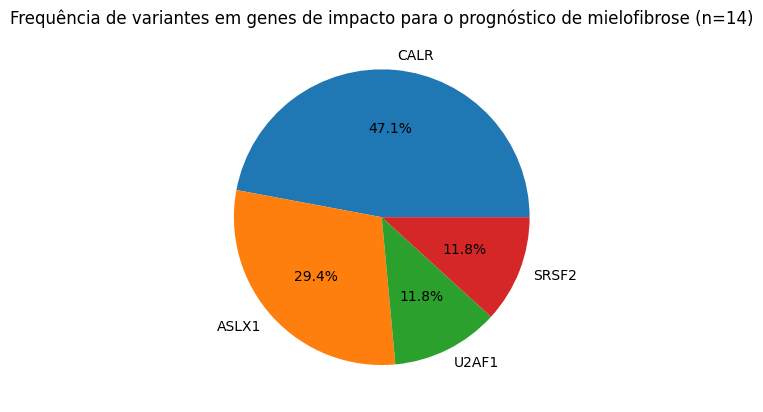

In [ ]:
import numpy as npimport
import matplotlib.pyplot as plt

#Prognóstico de Mielofibrose - variantes em genes de impacto mo score
labels = 'CALR', 'ASLX1', 'U2AF1', 'SRSF2', '(none)'
sections = [8, 5, 2, 2]

plt.pie(sections, labels=labels, autopct = '%1.1f%%')

plt.title('Frequência de variantes em genes de impacto para o prognóstico de mielofibrose (n=14)')
plt.show()

Na análise gráfica, dos 30 pacientes estudados, 14 apresentaram variantes nos genes-alvo selecionados para a avaliação prognóstica, conforme os critérios estabelecidos pelo GIPSS. Os 16 pacientes restantes, que não exibiram variantes, foram automaticamente atribuídos a uma pontuação de +1, uma vez que não possuíam a mutação protetora tipo 1 em CALR.

In [ ]:
#Exibindo os dados usando um dataframe pandas

import pandas as pd

data = {"TOTAL DE PACIENTES": [contagem[0],contagem[1],contagem[2],contagem[3]],
        "SCORE": ["0", "1", "2", ">=3"],
        "RISCO": ["Baixo", "Intermediário 1", "Intermediário 2", "Alto"],
        "SOBREVIDA EM 5 ANOS (%)": ["94,0%", "73,0%", "40,0%", "14,0%"],
        "SOBREVIDA MÉDIA (ANOS)": ["26,4 anos", "10,3 anos", "4,6 anos", "2,6 anos"]}

dataf = pd.DataFrame(data)

dataf.style.set_caption('ESTRATIFICADOR DE PROGNÓSTICO DE MIELOFIBROSE BASEADADO EM GIPSS (sem cariotipagem)')

,TOTAL DE PACIENTES,SCORE,RISCO,SOBREVIDA EM 5 ANOS (%),SOBREVIDA MÉDIA (ANOS)
0,6,0,Baixo,"94,0%","26,4 anos"
1,21,1,Intermediário 1,"73,0%","10,3 anos"
2,3,2,Intermediário 2,"40,0%","4,6 anos"
3,0,>=3,Alto,"14,0%","2,6 anos"


In [ ]:

criterios = {"Penalidade": ["+1", "+1", "+1", "+1"],
        "Achados": ["Ausência de deleção de 52pb em CALR", "Mutação em Exon 1 de SRSF2", "Mutação em Exon 12 de ASXL1", "Mutação Q157 em U2AF1"]}
criteriosf = pd.DataFrame(criterios)
criteriosf.style.set_caption('CRITÉRIOS DE PONTUAÇÃO BASEADO EM GIPSS (adaptado)')

,Penalidade,Achados
0,+1,Ausência de deleção de 52pb em CALR
1,+1,Mutação em Exon 1 de SRSF2
2,+1,Mutação em Exon 12 de ASXL1
3,+1,Mutação Q157 em U2AF1


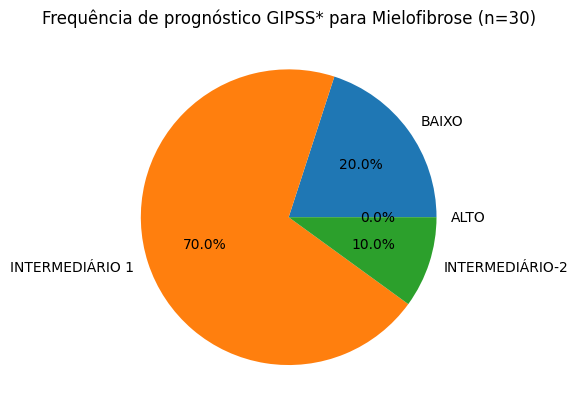

In [ ]:
import numpy as npimport
import matplotlib.pyplot as plt

#Prognóstico de Mielofibrose - GIPSS adaptado
labels = 'BAIXO', 'INTERMEDIÁRIO 1', 'INTERMEDIÁRIO-2', 'ALTO'
sections = [6,21, 3, 0 ]

plt.pie(sections, labels=labels, autopct = '%1.1f%%')

plt.title('Frequência de prognóstico GIPSS* para Mielofibrose (n=30)')
plt.show()

Dos 30 pacientes analisados, todos receberam um escore de risco, variando de 0 a >= 3, após a filtragem de genes e variantes com impacto no prognóstico de mielofibrose (MF). Utilizamos o guideline do GIPSS para esta avaliação, porém sem considerar a avaliação do cariótipo.

## **5) Pesquisa adicional de genes driver**

In [ ]:
#Cria uma lista.txt com 3 genes de DRIVERs marcadores de mielofibrose
!echo -e "CALR\nJAK2\nMPL\n" > /content/lmabrasil-hg38/hpo/mielofibrose_drivers.txt

#loop para processar pipeline de filtragem de genes drivers da lista SAMPLES
for i in SAMPLES:
  SAMPLE = i
  !echo {SAMPLE}
  !sh lmabrasil-hg38/vep-gc.sh {SAMPLE} mielofibrose_drivers.txt


import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#converte as 30 amostras filtradas pelo vep-gc.sh em amostras .csv --> output salvo na pasta /content/lmabrasil-hg38/csv_filtrados_driver
!mkdir /content/lmabrasil-hg38/csv_filtrados_driver
for i in SAMPLES:
  df = pd.read_csv(f'/content/lmabrasil-hg38/vep_output/liftOver_{i}_hg19ToHg38.vep.filter.tsv',sep='\t',index_col=False)
  df.to_csv(f'/content/lmabrasil-hg38/csv_filtrados_driver/{i}_filtrado.csv', index=False)

import glob
import pandas as pd

# Lista pasta com os 30 arquivos csv(s)
csv_files = glob.glob('/content/lmabrasil-hg38/csv_filtrados_driver/*.{}'.format('csv'))

#Une o resultado dos 30 arquivos csv(s) numa única tabela
df_concat = pd.concat([pd.read_csv(i) for i in csv_files], ignore_index=True)

#OUTPUT TABELA FINAL EM CSV
!mkdir /content/lmabrasil-hg38/tabela_final_driver
df_concat.to_csv('/content/lmabrasil-hg38/tabela_final_driver/tabela_final_driver.csv', index=False)

df_concat

WP048
 
 ****************************************************************************** 
 *                                                                            * 
 *               STARTING e0bb97aa-8455-371b-94ea-79c2c8bd9176                * 
 *                                                                            * 
 ****************************************************************************** 
 executing: filter_vep

-------------------- WARNING ----------------------
MSG: The script 'filter_vep' couldn't find the VEP annotations INFO field CSQ in 149 lines of the input file
FILE: src/ensembl-vep/filter_vep LINE: 345
CALLED BY: src/ensembl-vep/filter_vep  LINE: 55
Date (localtime)    = Wed Jan 31 20:05:30 2024
Ensembl API version = 111
---------------------------------------------------
         This message is printed only once.
WP093
 
 ****************************************************************************** 
 *                                                   

,CHROM,POS,REF,ALT,Location,SYMBOL,Consequence,Feature,MANE_SELECT,BIOTYPE,HGVSc,HGVSp,EXON,INTRON,VARIANT_CLASS,SIFT,PolyPhen,gnomADg_AF,MAX_AF,IMPACT,CLIN_SIG,SOMATIC,Existing_variation,FILTER,TumorID,GT,DP,AD,AF,NormalID,NGT,NDP,NAD,NAF
0,chr9,5073770,G,T,chr9:5073770,JAK2,missense_variant,NM_004972.4,ENST00000381652.4,protein_coding,NM_004972.4:c.1849G>T,NP_004963.1:p.Val617Phe,14/25,.,SNV,deleterious_low_confidence(0.01),probably_damaging(0.937),0.000362,0.000866,MODERATE,pathogenic&not_provided&conflicting_interpretations_of_pathogenicity&pathogenic/likely_pathogenic&likely_pathogenic&affects,0&0&1&1,rs77375493&CM123094&COSV67569051&COSV67571909,PASS,WP196,0/1,217,"143,74",0.329,WP197,0/0,121.0,"119,2",0.021
1,chr9,5054790,G,A,chr9:5054790,JAK2,missense_variant,NM_004972.4,ENST00000381652.4,protein_coding,NM_004972.4:c.842G>A,NP_004963.1:p.Gly281Asp,7/25,.,SNV,deleterious_low_confidence(0),benign(0.193),.,.,MODERATE,.,1,COSV67657749,PASS,WP087,0/1,141,"17,124",0.866,WP088,0/0,84.0,"84,0",0.013
2,chr9,5073770,G,T,chr9:5073770,JAK2,missense_variant,NM_004972.4,ENST00000381652.4,protein_coding,NM_004972.4:c.1849G>T,NP_004963.1:p.Val617Phe,14/25,.,SNV,deleterious_low_confidence(0.01),probably_damaging(0.937),0.0003621,0.0008661,MODERATE,pathogenic&not_provided&conflicting_interpretations_of_pathogenicity&pathogenic/likely_pathogenic&likely_pathogenic&affects,0&0&1&1,rs77375493&CM123094&COSV67569051&COSV67571909,PASS,WP087,0/1,193,"27,166",0.874,WP088,0/0,114.0,"114,0",0.011
3,chr9,5073770,G,T,chr9:5073770,JAK2,missense_variant,NM_004972.4,ENST00000381652.4,protein_coding,NM_004972.4:c.1849G>T,NP_004963.1:p.Val617Phe,14/25,.,SNV,deleterious_low_confidence(0.01),probably_damaging(0.937),0.000362,0.000866,MODERATE,pathogenic&not_provided&conflicting_interpretations_of_pathogenicity&pathogenic/likely_pathogenic&likely_pathogenic&affects,0&0&1&1,rs77375493&CM123094&COSV67569051&COSV67571909,PASS,WP295,0/1,214,"119,95",0.437,WP296,0/0,112.0,"109,3",0.046
4,chr19,12943750,AGCAGAGGCTTAAGGAGGAGGAAGAAGACAAGAAACGCAAAGAGGAGGAGGAG,A,chr19:12943751-12943802,CALR,frameshift_variant,NM_004343.4,ENST00000316448.10,protein_coding,NM_004343.4:c.1099_1150del,NP_004334.1:p.Leu367ThrfsTer46,9/9,.,deletion,.,.,0.00002,0.000066,HIGH,pathogenic,.,rs1555760738,map_qual,WP140,0/1,54,"35,19",0.399,WP141,0/0,25.0,"25,0",0.044
5,chr9,5073770,G,T,chr9:5073770,JAK2,missense_variant,NM_004972.4,ENST00000381652.4,protein_coding,NM_004972.4:c.1849G>T,NP_004963.1:p.Val617Phe,14/25,.,SNV,deleterious_low_confidence(0.01),probably_damaging(0.937),0.000362,0.000866,MODERATE,pathogenic&not_provided&conflicting_interpretations_of_pathogenicity&pathogenic/likely_pathogenic&likely_pathogenic&affects,0&0&1&1,rs77375493&CM123094&COSV67569051&COSV67571909,normal_artifact,WP066,0/1,200,"120,80",0.400,WP067,0/0,99.0,"95,4",0.053
6,chr9,5073770,G,T,chr9:5073770,JAK2,missense_variant,NM_004972.4,ENST00000381652.4,protein_coding,NM_004972.4:c.1849G>T,NP_004963.1:p.Val617Phe,14/25,.,SNV,deleterious_low_confidence(0.01),probably_damaging(0.937),0.000362,0.000866,MODERATE,pathogenic&not_provided&conflicting_interpretations_of_pathogenicity&pathogenic/likely_pathogenic&likely_pathogenic&affects,0&0&1&1,rs77375493&CM123094&COSV67569051&COSV67571909,PASS,WP216,0/1,180,"81,99",0.568,WP217,0/0,108.0,"107,1",0.023
7,chr1,43349337,TG,AA,chr1:43349337-43349338,MPL,missense_variant,NM_005373.3,ENST00000372470.9,protein_coding,NM_005373.3:c.1543_1544delinsAA,NP_005364.1:p.Trp515Lys,10/12,.,substitution,tolerated(0.06),benign(0.015),.,.,MODERATE,pathogenic,0&1&1,rs121913616&COSV65243979&COSV65244267,PASS,WP056,0/1,184,"90,94",0.520,WP057,0/0,81.0,"79,2",0.045
8,chr9,5073770,G,T,chr9:5073770,JAK2,missense_variant,NM_004972.4,ENST00000381652.4,protein_coding,NM_004972.4:c.1849G>T,NP_004963.1:p.Val617Phe,14/25,.,SNV,deleterious_low_confidence(0.01),probably_damaging(0.937),0.000362,0.000866,MODERATE,pathogenic&not_provided&conflicting_interpretations_of_pathogenicity&pathogenic/likely_pathoge

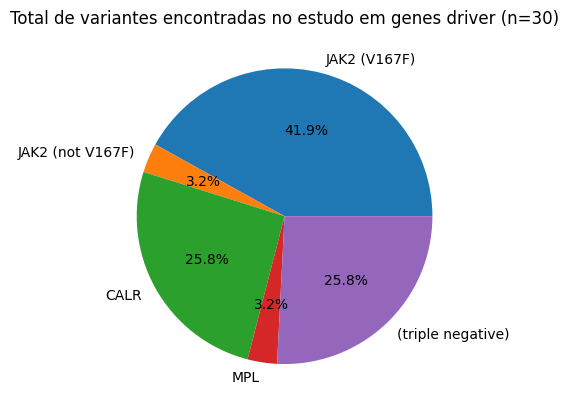

In [ ]:
import numpy as npimport
import matplotlib.pyplot as plt

#Quantidade de variantes em Genes Driver
labels = 'JAK2 (V167F)', 'JAK2 (not V167F)', 'CALR', 'MPL','(triple negative)',
sections = [13,1, 8, 1, 8]

plt.pie(sections, labels=labels, autopct = '%1.1f%%')

plt.title('Total de variantes encontradas no estudo em genes driver (n=30)')
plt.show()

Neste gráfico observa-se que, dos 30 pacientes avaliados, 22 apresentaram chamadas em genes condutores após a nossa filtragem, incluindo JAK2, CALR e MPL. Estes são reconhecidos como os principais marcadores de diagnóstico para mielofibrose.